In [118]:
#Importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [119]:
#Plotting function
def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [120]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

trainset=datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader=DataLoader(trainset, batch_size=64, shuffle=True)

testset=datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader=DataLoader(testset, batch_size=64, shuffle=False)

In [121]:
dataiter=iter(trainloader)
images, labels=dataiter.next()

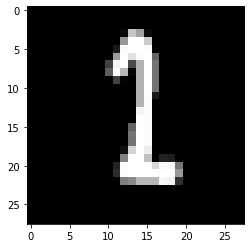

In [122]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [123]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1=nn.Conv2d(3, 32, 5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(32, 16, 5)
        self.fc1=nn.Linear(64*28*28, 128)
        self.fc2=nn.Linear(120, 64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x=x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        x=F.log_softmax(x, dim=1)
        return x

model=Network()

In [124]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


Network(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [125]:
criterion=nn.CrossEntropyLoss()
def torch_fit(trainloader, testloader, criterion, lr, num_epochs, model, device):
    optimizer=optim.Adam(model.parameters(), lr)

    train_losses=[]
    test_losses=[]
    accuracy=[]
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')

        train_epoch_loss=[]
        for i, (images, labels) in enumerate(iter(trainloader)):
            images=images.to(device)
            labels=labels.to(device)
            #images.resize_(images.size()[0], 784)
            print(images.shape)
            optimizer.zero_grad()
            pred=model.forward(images)
            loss=criterion(pred, labels)
            train_epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            
            test_epoch_list=[]
            acc_on_epoch=[]
            for j, (imagest, labelst) in enumerate(iter(testloader)):
                imagest=imagest.to(device)
                labelst=labelst.to(device)
                #imagest.resize_(imagest.size()[0], 784)
                preds=F.softmax(model(imagest), dim=1)
                losst=criterion(preds, labelst)
                test_epoch_list.append(losst.item())

                acc_pred=preds.argmax(dim=1)
                acc=(acc_pred == labelst).sum()/ len(labelst)
                acc_on_epoch.append(acc.item())
    
        mean_acc=sum(acc_on_epoch)/len(acc_on_epoch)
        accuracy.append(mean_acc)

        test_loss_mean=sum(test_epoch_list)/len(test_epoch_list)
        test_losses.append(test_loss_mean)

        train_loss_mean=sum(train_epoch_loss)/len(train_epoch_loss)
        train_losses.append(train_loss_mean)

        print(f'Mean epoch loss for train')
        print(f'Mean epoch loss for test: {test_loss_mean}')
        print(f'accuracy on epoch: {mean_acc}')

ans=torch_fit(trainloader=trainloader, testloader=testloader,criterion=criterion, lr=0.001, num_epochs=5, model=model, device=device)
    



Epoch: 1/5
torch.Size([64, 1, 28, 28])


RuntimeError: Given groups=1, weight of size [32, 3, 5, 5], expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead